# Neural Networks

We tried to test the use of some feedforward neural networks developed with the help of the Keras library, as well as scikeras. This last one was used in test 2, in order to combine this approach with a random search in order to quickly test a variety of models. The last one was one that Elena developed while I was writing the second test, and it seemed to be the highest performing one (although all of them had more or less the same performance).

In [1]:
from mlflow.create_dataset import Dataset, DATASET_TARGET_FEATURES
dataset = Dataset()
X,y = dataset.with_correlation()

data/df_encoded.csv


## Test 1: Simple neural network

This was the initial test.

### Model Creation

In [2]:
import keras as kr

FIT_PARAMS = {
    "batch_size": 64, # change this to try different tests
    "epochs": 100,
    "shuffle": True,
}
MODEL_NAME = "nn_1"

n_features = len(X.columns)
n_targets  = len(y.columns)
relu_slope = lambda x: kr.activations.relu(x, negative_slope=0.2)
nn_input = kr.Input(shape=(n_features,))
x = kr.layers.Dense(15, activation=relu_slope)(nn_input)
x = kr.layers.Dense(10, activation=relu_slope)(x)
x = kr.layers.Dense(7, activation=relu_slope)(x)
nn_output = kr.layers.Dense(n_targets, activation="softmax")(x)
model = kr.Model(inputs=nn_input, outputs=nn_output)
model.compile(
    optimizer=kr.optimizers.RMSprop(),  # Optimizer # type: ignore
    # Loss function to minimize
    loss=kr.losses.MeanSquaredError(),
    
    # List of metrics to monitor
    metrics=["accuracy", "auc"],
)

2024-12-26 16:47:41.974596: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 16:47:41.977153: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 16:47:41.984338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735228061.998791  357381 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735228062.003619  357381 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 16:47:42.018641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Training & Execution

In [3]:
import logging
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from mlflow.create_dataset import DATASET_TARGET_FEATURES


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
early_stopping = kr.callbacks.EarlyStopping(  # to improve the performance of the model
    monitor="val_auc", patience=10, restore_best_weights=True
)

model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    **FIT_PARAMS,
)
print(f"Model trained")


predictions: np.ndarray = model.predict(dataset.test)
predictions = predictions.transpose()

h1n1_probs = predictions[0][:]
# Probabilidades de clase positiva para h1n1_vaccine
seasonal_probs = predictions[1][:]
# Probabilidades de clase positiva para seasonal_vaccine

predict = pd.DataFrame(
    {
        "respondent_id": dataset.test.index,
        "h1n1_vaccine": h1n1_probs,
        "seasonal_vaccine": seasonal_probs,
    }
)
predict.set_index("respondent_id", inplace=True)
predict.to_csv(f"predictions_{MODEL_NAME}.csv")
print("predictions saved")

Epoch 1/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3538 - auc: 0.6535 - loss: 0.2366 - val_accuracy: 0.4435 - val_auc: 0.6995 - val_loss: 0.2261
Epoch 2/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3647 - auc: 0.7065 - loss: 0.2229 - val_accuracy: 0.3609 - val_auc: 0.7108 - val_loss: 0.2219
Epoch 3/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3914 - auc: 0.7182 - loss: 0.2191 - val_accuracy: 0.3731 - val_auc: 0.7140 - val_loss: 0.2204
Epoch 4/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3976 - auc: 0.7153 - loss: 0.2194 - val_accuracy: 0.3658 - val_auc: 0.7151 - val_loss: 0.2198
Epoch 5/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3974 - auc: 0.7146 - loss: 0.2198 - val_accuracy: 0.3540 - val_auc: 0.7159 - val_loss: 0.2197
Epoch 6/100
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3909 - auc: 0.7170 - loss: 0.2190 - val_accuracy: 0.3746 - val_auc: 0.7168 - val_loss: 0.2193
Epoch 7/100
334/334 ━━━━━━━━━━━━━━

### Results

In [4]:

model.compute_metrics(X_test, y_test, model.predict(X_test))
accuracy = model.get_metrics_result()["accuracy"]
roc_auc = model.get_metrics_result()["auc"]

print(f"""
Results:
- roc_auc: {roc_auc}
- accuracy: {accuracy}
""")

167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step

Results:
- roc_auc: 0.7198323607444763
- accuracy: 0.36624860763549805



## Test 2: Use of random search over several Keras Models 

Doesn't work in Jupyter notebook, because of an error. Since this does not happen in the original test, this can be run from the code in the mlflow folder.


### Model Creation

In [5]:
from scipy.stats import uniform
from scikeras.wrappers import KerasClassifier

NAME = "nn_2_si_opt"

PARAMS =  {
    # learning algorithm parameters
    # activation
    # "act": [relu_slope, "sigmoid"],
    # numbers of layers
    # # dropout and regularisation
    # "dropout": [0, 0.1, 0.2, 0.3],
    # "l1": [0, 0.01, 0.003, 0.001, 0.0001],
    # "l2": [0, 0.01, 0.003, 0.001, 0.0001],
    # "rs_num": [0.2,0.3,0.4],
    # neurons in each layer
    "shape" : [
        (50,),
        (50, 25),
        (100, 50, 20),
        (100, 50, 25),
        (100, 50, 25, 10),
        (200, 100, 50, 25),
        (200, 100, 50, 25, 10)
    ],
    "act": ["relu","tanh"],
    "learn_rate": uniform(0.0001,0.01),
    # "alpha": uniform(0.0001,0.01),
    # "max_iter": randint(200,1000),
}

FIT_PARAMS= {
    "epochs": 100,
    "verbose": 0,
}


def create_model(
    shape,
    act,
    # rs_num,
    learn_rate,
    # alpha,
    # max_iter,
    input_shape,
    output_shape,
):
    """This is a model generating function so that we can search over neural net
    parameters and architecture"""
    # act = lambda x: kr.activations.relu(x, negative_slope=rs_num)
    model = kr.models.Sequential()

    # for the firt layer we need to specify the input dimensions
    first = True

    for i in shape:
        if first:
            model.add(kr.layers.Dense((input_shape,)))
        else:
            model.add(kr.layers.Dense(i,activation=act))

    model.add(kr.layers.Dense(output_shape, activation="softmax"))
    model.compile(
        loss=kr.losses.MeanSquaredError(),
        metrics=["accuracy", "auc"],
        optimizer=kr.optimizers.Adam(learning_rate=learn_rate),
    )
    return model


model = KerasClassifier(
    build_fn=create_model,
    # act=relu_slope,
    # rs_num=0.2,
    # dropout=0,
    shape = (100,),
    act="relu",
    # rs_num = 0.2,
    learn_rate=0.001,
    # alpha=0.001,
    # max_iter=400,
    input_shape=X.shape[1],
    output_shape=y.shape[1],
)


### Training & Execution

In [6]:
import logging
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model_params = PARAMS | {
    "input_shape": [X.shape[1]],
    "output_shape": [y.shape[1]],
}

model_rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=model_params,
    n_iter=1,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring="roc_auc",
)

# print(f"Model parameters:\n{model_params}\n\nFit parameters:\n{FIT_PARAMS}")
model_rs.fit(X_train, y_train, **FIT_PARAMS)
print(f"Model trained")
y_pred = model_rs.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro")
logging.info("Model evaluated")

pd_train = pd.concat([X_train, y_train], axis=1)

predictions = model_rs.predict_proba(dataset.test[dataset.test.columns.difference(DATASET_TARGET_FEATURES)])

predictions = predictions.transpose()
h1n1_probs = predictions[0][:]
# Probabilidades de clase positiva para h1n1_vaccine
seasonal_probs = predictions[1][:]
# Probabilidades de clase positiva para seasonal_vaccine

predict = pd.DataFrame(
    {
        "respondent_id": dataset.test.index,
        "h1n1_vaccine": h1n1_probs,
        "seasonal_vaccine": seasonal_probs,
    }
)
predict.set_index("respondent_id", inplace=True)
predict.to_csv(f"predictions_{NAME}.csv")
print("predictions saved")

2024-12-26 16:48:11.147666: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 16:48:11.149958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 16:48:11.150500: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 16:48:11.154073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-26 16:48:11.161165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-26 16:48:11.168941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mariojr/DocumentosCACHE/Uni ESI Grado Informatica/2024-2025/1º Semestre/ML/Lab/MachineLearning-24-25-ProgressTasks/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mariojr/DocumentosCACHE/Uni ESI Grado Informatica/2024-2025/1º Semestre/ML/Lab/MachineLearning-24-25-ProgressTasks/.venv/lib/python3.10/site-packages/scikeras/wrappers.py", line 1501, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/mariojr/DocumentosCACHE/Uni ESI Grado Informatica/2024-2025/1º Semestre/ML/Lab/MachineLearning-24-25-ProgressTasks/.venv/lib/python3.10/site-packages/scikeras/wrappers.py", line 770, in fit
    self._fit(
  File "/home/mariojr/DocumentosCACHE/Uni ESI Grado Informatica/2024-2025/1º Semestre/ML/Lab/MachineLearning-24-25-ProgressTasks/.venv/lib/python3.10/site-packages/scikeras/wrappers.py", line 936, in _fit
    self._check_model_compatibility(y)
  File "/home/mariojr/DocumentosCACHE/Uni ESI Grado Informatica/2024-2025/1º Semestre/ML/Lab/MachineLearning-24-25-ProgressTasks/.venv/lib/python3.10/site-packages/scikeras/wrappers.py", line 559, in _check_model_compatibility
    if self.n_outputs_expected_ != len(self.model_.outputs):
  File "/home/mariojr/DocumentosCACHE/Uni ESI Grado Informatica/2024-2025/1º Semestre/ML/Lab/MachineLearning-24-25-ProgressTasks/.venv/lib/python3.10/site-packages/keras/src/models/sequential.py", line 300, in outputs
    raise AttributeError(
AttributeError: Sequential model 'sequential' has no defined outputs yet.. Did you mean: 'output'?


### Results

In [ ]:
print(f"""
Results:
- roc_auc: {roc_auc}
- accuracy: {accuracy}
""")

## Test 3: Bigger neural network, with a some dropout layers in between

Elena developed this model, and it is the same as the one developed in test1, although with a far larger size, and larger amount of layers in between.

### Model Creation

In [11]:
FIT_PARAMS = {
    "batch_size": 64, # change this to try different tests
    "epochs": 100,
    "shuffle": True,
}
MODEL_NAME = "nn_3"

nn_input = kr.Input(shape=(n_features,))
x = kr.layers.Dense(512, activation='relu')(nn_input) #what ever other input and activation function
x = kr.layers.Dense(256, activation='relu', kernel_regularizer=kr.regularizers.l2(0.01))(x)
x = kr.layers.Dropout(0.3)(x)
x = kr.layers.Dense(128, activation='relu')(x)
x = kr.layers.Dense(64, activation='sigmoid')(x)
x = kr.layers.Dropout(0.2)(x)
x = kr.layers.Dense(32, activation='relu')(x)
nn_output = kr.layers.Dense(n_targets, activation="sigmoid")(x) # SIGMOID better than SOFTMAX

model = kr.Model(inputs=nn_input, outputs=nn_output)
model.compile(
    optimizer=kr.optimizers.Adam(learning_rate=0.001),  
    # Loss function to minimize
    loss=kr.losses.BinaryCrossentropy(), # THIS ONE DO NOT CHANGE
    # List of metrics to monitor
    metrics=["accuracy", kr.metrics.AUC(name="auc", multi_label=True)],
)

### Training & Execution

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from mlflow.create_dataset import DATASET_TARGET_FEATURES


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=43, stratify=y
)
early_stopping = kr.callbacks.EarlyStopping(  # to improve the performance of the model
    monitor="val_auc", patience=10, restore_best_weights=True
)

model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    **FIT_PARAMS,
)
print(f"Model trained")


predictions: np.ndarray = model.predict(dataset.test)
predictions = predictions.transpose()

h1n1_probs = predictions[0][:]
# Probabilidades de clase positiva para h1n1_vaccine
seasonal_probs = predictions[1][:]
# Probabilidades de clase positiva para seasonal_vaccine

predict = pd.DataFrame(
    {
        "respondent_id": dataset.test.index,
        "h1n1_vaccine": h1n1_probs,
        "seasonal_vaccine": seasonal_probs,
    }
)
predict.set_index("respondent_id", inplace=True)
predict.to_csv(f"predictions_{MODEL_NAME}.csv")
print("predictions saved")

### Results

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from scikeras.wrappers import KerasClassifier

model.compute_metrics(X_test, y_test, model.predict(X_test))
accuracy = model.get_metrics_result()["accuracy"]
roc_auc = model.get_metrics_result()["auc"]

print(f"""
Results:
- roc_auc: {roc_auc}
- accuracy: {accuracy}
""")
# ConfusionMatrixDisplay.from_predictions(y_test,model.predict(X_test))
# KerasClassifier(model).predict(X_test)

We uploaded this last model to the contest, since it had the highest metrics in ROC and accuracy, and these were the results:

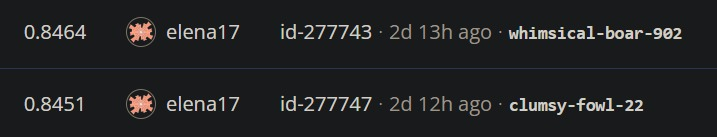